In [78]:
import abjad
%load_ext abjad.ext.ipython

The abjad.ext.ipython extension is already loaded. To reload it, use:
  %reload_ext abjad.ext.ipython


## Toward a Music-Generating Class -- Isorhythm

The rhythmmaker classes we saw yesterday are a good example of top-down music generation. Today, we'll learn to write new classes that generate music in a similar top-down fashion.

To begin with, we're going to model the process of generation in a completely procedural way; later, we'll get into basics of object-oriented programming and turn this procedural code into a reusable class.

First, we'll just use an instance of the `Talea()` class to generate some leaves; this is basically what an instance of the `TaleaRhythmmaker()` class is doing. Then we'll paint a cycle of pitches (a *color*) onto the generated leaves.

In [79]:
time_signature_pairs = [(4, 4), (3, 4), (7, 16), (6, 8)]
total_duration = sum(abjad.Duration(pair) for pair in time_signature_pairs)
counts = [1, 2, -3, 4]
denominator = 16
talea = abjad.rhythmmakertools.Talea(counts=counts, denominator=denominator)
talea_index = 0

The talea generates a cycle of fractions by pairing each count with its denominator. Negative numerators indicate rests.

In [80]:
talea[:10]

[NonreducedFraction(1, 16),
 NonreducedFraction(2, 16),
 NonreducedFraction(-3, 16),
 NonreducedFraction(4, 16),
 NonreducedFraction(1, 16),
 NonreducedFraction(2, 16),
 NonreducedFraction(-3, 16),
 NonreducedFraction(4, 16),
 NonreducedFraction(1, 16),
 NonreducedFraction(2, 16)]

### 1. Generate the Rhythms
Let's use the talea to generate a series of middle Cs that add up to the total duration of the time signature series defined above.

In [81]:
all_leaves = [] # create an empty list for generated leaves
current_duration = abjad.Duration(0) # keep track of the total duration as we generate each new leaf
while current_duration < total_duration: # generate leaves until they add up to the total duration
    leaf_duration = talea[talea_index] # get a fraction from the talea
    if leaf_duration > 0: 
        pitch = abjad.NamedPitch("c'") # assign the leaf a pitch of middle C
    else:
        pitch = None # if the leaf is a rest, don't assign a pitch
    leaf_duration = abs(leaf_duration) # cancel the minus sign on the duration
    if (leaf_duration + current_duration) > total_duration:
        leaf_duration = total_duration - current_duration # catch any end condition by truncating the last duration
    current_leaves = abjad.LeafMaker()([pitch], [leaf_duration])   # make the leaves
    all_leaves.extend(current_leaves) # add the new leaves to the list of leaves
    current_duration += leaf_duration # advance the total duration
    talea_index += 1 # advance the talea index to the next fraction

In [82]:
music = abjad.Container(all_leaves) # put the leaves into a container for ease of further use

Now we need to split the generated leaves at measure boundaries so that they fit into the time signatures we specified.

In [83]:
shards = abjad.mutate(music[:]).split(time_signature_pairs)
for i, shard in enumerate(shards):
    abjad.mutate(shard[:]).wrap(abjad.Measure(abjad.TimeSignature(time_signature_pairs[i])))
    

Let's also put each measure into a `Measure()` instance for ease of further access.

In [84]:
shards = abjad.mutate(music[:]).split(time_signature_pairs)
for i, shard in enumerate(shards):
    measure = abjad.Measure(time_signature_pairs[i])

Have a look at the resulting LilyPond output to confirm that we now have both measures -- interior curly braces -- and also time signatures for each measure.

In [85]:
abjad.f(music)

{
    {
        \time 4/4
        c'16
        c'8
        r8.
        c'4
        c'16
        c'8
        r8.
    }
    {
        \time 3/4
        c'4
        c'16
        c'8
        r8.
        c'8 ~
    }
    {
        \time 7/16
        c'8
        c'16
        c'8
        r8
    }
    {
        \time 6/8
        r16
        c'4
        c'16
        c'8
        r8.
        c'16
    }
}


### 2. Paint on the Pitches
And now we can paint a cycle of pitches onto the generated rhythms however we like. First, we define a cycle of pitches:

In [86]:
#pitches = abjad.CyclicTuple(["d'", "a''", "gs'", "fs'"])
#pitches = abjad.CyclicTuple(["c'", "c''"])
#pitches = abjad.CyclicTuple([0, 2, 4, 5, 7, 9, 11, 12])
pitches = abjad.CyclicTuple([0, 3, 7, 12, 7, 3])

And then we apply the pitches to our previously generated durations:

In [87]:
logical_ties = abjad.iterate(music).by_logical_tie(pitched=True)
for i, logical_tie in enumerate(logical_ties):
    pitch = pitches[i]
    for note in logical_tie:
        note.written_pitch = pitch

And now we have both pitches and rhythms:

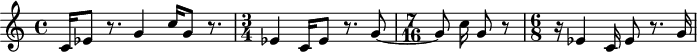

In [88]:
abjad.show(music)

### 3. Compositional Detailing

Finally, we can iterate through runs of leaves to further detail each gesture with articulations, dynamics, and technical indications.

In [55]:
for run in abjad.select(music).by_leaf().by_run((abjad.Note, abjad.Chord)):
    abjad.attach(abjad.Articulation('accent'), run[0])
    if 1 < len(run):
        abjad.attach(abjad.Hairpin('p < f'), run)
    else:
        abjad.attach(abjad.Dynamic('ppp'), run[0])

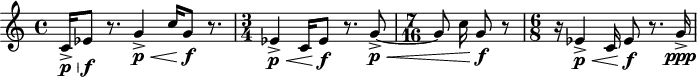

In [56]:
abjad.show(music)

### 4. Metric Legibility
But you still wouldn't want to have to read the music we generated. To obey conventions of metric notation, we impose a metric hierarchy on each of the measures, according to each meter's default divisions. See Day Two's notebooks for how to impose a metric hierarchy on notation.)

## Conclusion
This is a completely procedural view on the creation code that generates pitches and rhythms. Next, we'll take an object-oriented view of the same kind of music generator.